# Figure 7

[Skip code and jump to the figure](#Show-the-figure)

----------------------------------

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
# Scientific and datavis stack
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm

In [3]:
# My packages
from aeolus.calc import spatial_mean, time_mean, zonal_mean
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units
from pouch.clim_diag import (
    calc_derived_cubes,
    longitude_of_wave_crest,
)
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_ZERO_LINE,
    XLOCS,
    YLOCS,
    figsave,
    linspace_pm1,
    use_style,
)

In [4]:
# Local modules
import mypaths
from commons import (
    GLM_SUITE_ID,
    OPT_LABELS,
    REGIMES,
    SENS_EXP_GROUPS,
    SIM_LABELS,
    eq_lat,
    free_troposphere,
    troposphere,
)

Apply custom matplotlib style sheet.

In [5]:
use_style()

## Load model data from the two key experiments

Define paths to input data and results.

In [6]:
img_prefix = f"{GLM_SUITE_ID}_mean"
inp_dir = mypaths.sadir / f"{GLM_SUITE_ID}_mean"
# time_prof = "mean_days6000_9950"
plotdir = mypaths.plotdir / img_prefix

Load processed data.

In [7]:
runs = {}
runs_p = {}
for sim_label, sim_prop in SIM_LABELS.items():
    planet = sim_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    if sim_label == "base":
        time_prof = "mean_days6000_9950"
    elif sim_label == "sens-noradcld":
        time_prof = "mean_days2000_2200"
    else:
        time_prof = "mean_days2000_2950"
    cl = load_data(
        files=inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}.nc",
    )

    add_planet_conf_to_cubes(cl, const)
    # Use the cube list to initialise an AtmoSim object
    calc_derived_cubes(cl, const=const)
    runs[sim_label] = AtmoSim(
        cl,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
    )
    # Cubes on pressure levels
    cl_p = load_data(inp_dir / f"{GLM_SUITE_ID}_{sim_label}_{time_prof}_plev.nc")
    runs_p[sim_label] = AtmoSim(
        cl_p,
        name=sim_label,
        planet=planet,
        const_dir=mypaths.constdir,
        timestep=cl[0].attributes["timestep"],
        model=um,
        vert_coord="p",
    )

## Choose variables

Define two key pressure levels (also used for other figures).

In [8]:
P_LEV1 = 300  # hPa
p_lev_constr1 = iris.Constraint(**{um.pres: P_LEV1 * 1e2})
P_LEV2 = 500  # hPa
p_lev_constr2 = iris.Constraint(**{um.pres: P_LEV2 * 1e2})

Store final results in a separate dictionary.

In [9]:
RESULTS = {}
for sim_label in SIM_LABELS.keys():
    RESULTS[sim_label] = {}

    the_run = runs[sim_label]  # variables on model levels
    the_run_p = runs_p[sim_label]  # variables on pressure levels

    # Coordinates
    RESULTS[sim_label]["lons"] = the_run.coord.x.points
    RESULTS[sim_label]["lats"] = the_run.coord.y.points
    # Chosen pressure levels in sigma-pressure coordinates
    RESULTS[sim_label]["sigma_p"] = time_mean(spatial_mean(the_run.sigma_p))
    RESULTS[sim_label]["sigma_p_lev1"] = (
        P_LEV1 * 1e2 / the_run.const.reference_surface_pressure.data
    )
    RESULTS[sim_label]["sigma_p_lev2"] = (
        P_LEV2 * 1e2 / the_run.const.reference_surface_pressure.data
    )

    # Geopotential height
    ghgt = the_run_p.ghgt.extract(p_lev_constr1) / the_run_p.const.gravity
    RESULTS[sim_label]["ghgt_dev"] = time_mean(ghgt - zonal_mean(ghgt))
    # Longitude of the planetary-scale wave calculated from the geopotential height
    wave_crest_lon = longitude_of_wave_crest(ghgt)
    RESULTS[sim_label]["wave_crest_lon"] = wave_crest_lon
    RESULTS[sim_label]["wave_crest_lon_tm"] = time_mean(wave_crest_lon)
    # Air temperature at a pressure level in mid-troposphere
    RESULTS[sim_label]["temp_map"] = time_mean(the_run_p.temp.extract(p_lev_constr2))
    # Horizontal wind and its deviation from the zonal mean
    u = the_run_p.u.extract(p_lev_constr1)
    v = the_run_p.v.extract(p_lev_constr1)
    u_map = time_mean(u)
    v_map = time_mean(v)
    RESULTS[sim_label]["u_map"] = u_map
    RESULTS[sim_label]["v_map"] = v_map
    RESULTS[sim_label]["u_eddy_map"] = time_mean(u - zonal_mean(u))
    RESULTS[sim_label]["v_eddy_map"] = time_mean(v - zonal_mean(v))

## Create a figure

Define plotting style for the variables.

In [10]:
# Plot style for wind vectors
KW_QUIVER = dict(
    scale_units="inches",
    scale=200,
    facecolors=("#444444"),
    edgecolors=("#EEEEEE"),
    linewidths=0.15,
    width=0.004,
    headaxislength=4,
)
KW_QUIVER_EDDY = {**KW_QUIVER, **{"scale": 100}}

KW_QUIVERKEY = dict(
    labelpos="N",
    labelsep=0.05,
    coordinates="axes",
    color="#444444",
    fontproperties=dict(size="xx-small"),
)

# KW_CBAR = dict(fraction=0.0125, aspect=15, pad=0.025)
KW_CBAR = dict(pad=0.01)
KW_CBAR_TTL = dict(size="medium")

xstride = 8
ystride = 6
xsl = slice(None, None, xstride)
ysl = slice(None, None, ystride)

KW_TEMP = dict(
    levels=np.arange(100, 1000, 5),
    cmap=cm.batlow,
    norm=mpl.colors.Normalize(vmin=210, vmax=260),
    extend="both",
)

Assemble the figure.

In [11]:
imgname = f"{img_prefix}__{'_'.join(SIM_LABELS.keys())}__temp_{P_LEV1}hpa_winds_ghgt_dev_map_{P_LEV2}hpa"

ncols = 2
nrows = 2

fig, axs = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 6),
    gridspec_kw=dict(hspace=0.3, wspace=0.15),
)

iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
for ax in axs[:2, :].flat:
    ax.set_ylim(-90, 90)
    ax.set_yticks(YLOCS)
    ax.set_xlim(-180, 180)
    ax.set_xticks(XLOCS)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Latitude [$\degree$]", fontsize="small")
    if not ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Longitude [$\degree$]", fontsize="small")

for (sim_label, sim_prop), axcol in zip(SIM_LABELS.items(), axs.T):
    axcol[0].set_title(sim_prop["title"], **KW_MAIN_TTL)

    ax = axcol[0]
    _p0 = ax.contourf(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["temp_map"].data,
        **KW_TEMP,
    )
    ax.contour(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["temp_map"].data,
        colors="tab:red",
        levels=KW_TEMP["levels"],
        linewidths=0.5,
    )
    _q = ax.quiver(
        RESULTS[sim_label]["lons"][xsl],
        RESULTS[sim_label]["lats"][ysl],
        RESULTS[sim_label]["u_map"].data[ysl, xsl],
        RESULTS[sim_label]["v_map"].data[ysl, xsl],
        **KW_QUIVER,
    )
    qk_ref_wspd = 30
    ax.quiverkey(
        _q,
        *(0.95, 1.025),
        qk_ref_wspd,
        fr"${qk_ref_wspd}$" + r" $m$ $s^{-1}$",
        **KW_QUIVERKEY,
    )

    ax = axcol[1]
    _p1 = ax.contourf(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["ghgt_dev"].data,
        cmap=cm.roma_r,
        levels=linspace_pm1(10) * 500,
        extend="both",
    )
    ax.contour(
        RESULTS[sim_label]["lons"],
        RESULTS[sim_label]["lats"],
        RESULTS[sim_label]["ghgt_dev"].data,
        levels=linspace_pm1(10) * 500,
        colors="tab:grey",
        linewidths=0.5,
    )
    _q = ax.quiver(
        RESULTS[sim_label]["lons"][xsl],
        RESULTS[sim_label]["lats"][ysl],
        RESULTS[sim_label]["u_eddy_map"].data[ysl, xsl],
        RESULTS[sim_label]["v_eddy_map"].data[ysl, xsl],
        **KW_QUIVER_EDDY,
    )
    qk_ref_wspd = 15
    _qk = ax.quiverkey(
        _q,
        *(0.95, 1.025),
        qk_ref_wspd,
        fr"${qk_ref_wspd}$" + r" $m$ $s^{-1}$",
        **KW_QUIVERKEY,
    )
    ax.plot(
        [
            RESULTS[sim_label]["wave_crest_lon"].data,
            RESULTS[sim_label]["wave_crest_lon"].data,
        ],
        [-90, 90],
        color="tab:cyan",
        linewidth=0.5,
        alpha=0.5,
    )
    ax.plot(
        [
            RESULTS[sim_label]["wave_crest_lon_tm"].data,
            RESULTS[sim_label]["wave_crest_lon_tm"].data,
        ],
        [-90, 90],
        color="tab:cyan",
        linewidth=2,
    )

_cbar0 = fig.colorbar(_p0, ax=axs[0, :], **KW_CBAR)
_cbar0.ax.set_ylim(KW_TEMP["norm"].vmin, KW_TEMP["norm"].vmax)
_cbar0.set_ticks(
    np.arange(
        KW_TEMP["norm"].vmin,
        KW_TEMP["norm"].vmax + np.diff(KW_TEMP["levels"])[0],
        np.diff(KW_TEMP["levels"])[0],
    )
)
_cbar0.ax.tick_params(colors="tab:red")
_cbar0.ax.set_ylabel(f"{P_LEV2} hPa temperature [$K$]", color="tab:red", **KW_CBAR_TTL)
_cbar1 = fig.colorbar(_p1, ax=axs[1, :], **KW_CBAR)
_cbar1.ax.set_ylabel(f"{P_LEV1} hPa height anomaly [$m$]", **KW_CBAR_TTL)

plt.close()

# Show the figure

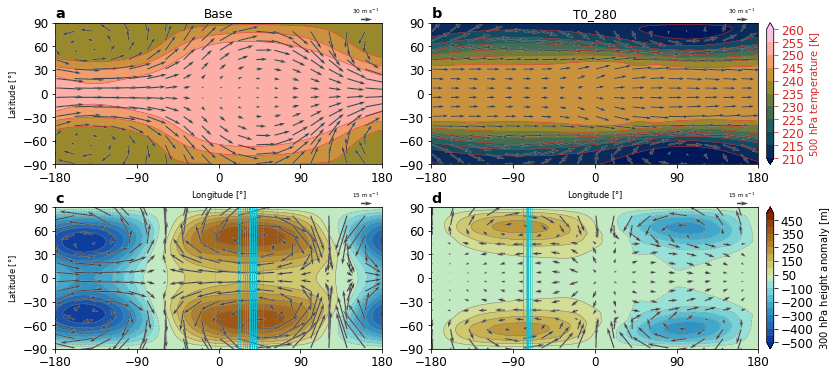

In [12]:
fig

* **Steady state atmospheric circulation in the (left) _Base_ (SJ regime) and (right) _T0\_280_ (DJ regime) simulations.**
* **The panels show (a, b) $500\,hPa$ temperature (shading, $K$) with $300\,hPa$ wind vectors, (c, d) $300\,hPa$ eddy geopotential height (shading, $m$) and eddy wind vectors.**
* **The cyan lines in the bottom panels show the longitude of the planetary wave crest, defined as the maximum of the geopotential height anomaly.**
* **Thin cyan lines show the 50-day mean longitude for several time periods of the steady state climate, while the thick cyan line shows the overall time mean longitude.**
* **The geopotential height anomaly is defined as the deviation from the zonal mean of the height of the $300\,hPa$ isobaric surface.**

In [13]:
figsave(fig, plotdir / imgname)

Saved to ../plots/ch111_mean/ch111_mean__base_sens-t280k__temp_300hpa_winds_ghgt_dev_map_500hpa.png
